Saving 1-36 - Copy.jpg to 1-36 - Copy.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


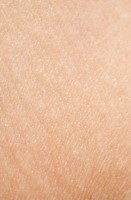

نتیجه تشخیص:
پوست سالم شناسایی شد


Text(value='', description='ادامه؟', placeholder='برای ادامه بنویسید: بله')

Button(description='تأیید', style=ButtonStyle())

In [2]:
# 1. نصب کتابخانه‌های مورد نیاز
!pip install tensorflow scikit-learn matplotlib gdown

# 2. وارد کردن کتابخانه‌ها برای پردازش تصویر و مدل سازی و تعامل با کاربر و کار با محیط کولب
import os
import zipfile
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import files
from IPython.display import display, Image
import tensorflow as tf
import ipywidgets as widgets
from IPython.display import clear_output

# تعریف مسیر ذخیره‌مدل
model_path = 'skin_cancer_model.h5'

# 3. دانلود دیتاست فقط اگر قبلاً دانلود نشده باشد
if not os.path.exists('ham10000.zip'):
    !gdown --id 1mTK7p5ZoCyYl9Tx1eKdS2wTi-4pqaCAH -O ham10000.zip
if not os.path.exists('healthy_skin.zip'):
    !gdown --id 1NEWYquTpQhoPOg0eAQxR_mzg3JoTaSNc -O healthy_skin.zip

# 4. استخراج فایل‌ها اگر قبلاً استخراج نشده‌اند
if not os.path.exists('ham10000'):
    with zipfile.ZipFile('ham10000.zip', 'r') as zip_ref:
        zip_ref.extractall('ham10000')
if not os.path.exists('healthy_skin'):
    with zipfile.ZipFile('healthy_skin.zip', 'r') as zip_ref:
        zip_ref.extractall('healthy_skin')

# 5. ساخت دایرکتوری‌ها و انتقال تصاویر فقط اگر دایرکتوری‌ها خالی باشند
if not os.path.exists('dataset/train/cancer'):
    os.makedirs('dataset/train/cancer', exist_ok=True)
    os.makedirs('dataset/train/healthy', exist_ok=True)

    cancer_images = os.listdir('ham10000')
    for img in cancer_images[:900]:
        shutil.move(f'ham10000/{img}', f'dataset/train/cancer/{img}')

    healthy_images = os.listdir('healthy_skin')
    for img in healthy_images[:900]:
        shutil.move(f'healthy_skin/{img}', f'dataset/train/healthy/{img}')

# 6. آماده‌سازی داده‌ها مثل تغییر اندازه تصاویر
image_size = (128, 128)
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = datagen.flow_from_directory(
    'dataset/train', target_size=image_size, batch_size=32, class_mode='categorical', subset='training')
val_generator = datagen.flow_from_directory(
    'dataset/train', target_size=image_size, batch_size=32, class_mode='categorical', subset='validation')

# 7. بررسی وجود مدل و در صورت نبود، آموزش و ذخیره مدل
if os.path.exists(model_path):
    print("✅ مدل موجود است. در حال بارگذاری مدل از فایل ...")
    model = load_model(model_path)
else:
    print("📌 مدل موجود نیست. در حال آموزش مدل جدید ...")
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[early_stop])
    model.save(model_path)
    print("✅ مدل ذخیره شد.")

# 8. تابع پیش‌بینی تصویر
def predict_image(img_path):
    img = load_img(img_path, target_size=image_size)
    img_array = img_to_array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array)
    class_index = np.argmax(pred)
    if class_index == 0:
        result = "پوست سرطانی شناسایی شد"
    else:
        result = "پوست سالم شناسایی شد"
    display(Image(filename=img_path))
    print("نتیجه تشخیص:")
    print(result[::1])

# 9. تعامل با کاربر برای آپلود و تشخیص
def interaction_loop():
    confirm_text = widgets.Text(
        value='', placeholder='برای ادامه بنویسید: بله', description='ادامه؟', disabled=False)
    button = widgets.Button(description="تأیید")

    def on_button_clicked(b):
        clear_output(wait=True)
        if confirm_text.value.strip() == 'بله':
            uploaded = files.upload()
            for fn in uploaded.keys():
                predict_image(fn)
            interaction_loop()   # اجرای دوباره برای تصویر بعدی
        else:
            print("پایان برنامه.")

    button.on_click(on_button_clicked)
    display(confirm_text, button)

interaction_loop()